## Import

In [1]:
import numpy as np
import pandas as pd
from math import sqrt 
import matplotlib.pyplot as plt
from matplotlib import rcParams
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

%matplotlib inline
#%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)


2.9.1


## load dataset

In [2]:
dataset = pd.read_csv('eMalahleniIM.csv', sep =';', header=0, index_col=0)
values = dataset.values

## Plot pm2.5

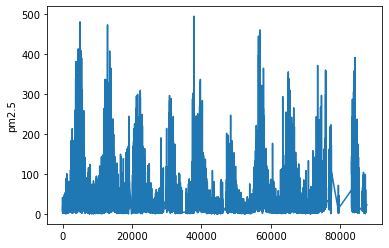

In [3]:
plt.plot(values[:,0])
plt.ylabel(dataset.columns[0])
plt.show()

## Data preparation

We need a way to prepare the data for whatever way we would like to formulate the problem.

In this case we are formulating it such that we take in 1 time step input (14 variables) and output 1 time step output (1 variable). In other words we are trying to solve the following question: given the pollution and weather conditions of the previous hour, can we predict the PM2.5 level for the next hour.

The single variable we are outputing is the PM2.5 level. Note we also use PM2.5 level in our input.

Credit for this code: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Get column names

In [5]:
dataset.columns

Index(['pm2.5', 'pm10', 'so2', 'no2', 'no', 'nox', 'o3', 'co', 'ws', 'wd',
       'temp', 'relHum', 'pressure'],
      dtype='object')

##Actually perform the data preparation

We scale the values between 0 and 1.

The code which converts the data into the suitable way we want, in this case, will produce 14 output variables. In our case we only want to predict PM2.5, that is why we drop the other collumns from the dataframe.

Credit for this code: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [6]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
# We drop these because we are only interested in predicting for a single variable (pollution).
# If we don't drop, then we will be predicting for all the variables too!
reframed.drop(reframed.columns[[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]], axis=1, inplace=True)
values = reframed.values

## View the data

In [7]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var1(t)
1,0.018966,0.016509,0.017832,0.023121,0.007442,0.015058,0.380849,0.004532,0.487526,0.493486,0.546332,0.833146,0.549068,0.026136
2,0.026136,0.016882,0.069390,0.088378,0.006463,0.036362,0.334627,0.003827,0.455301,0.539821,0.503610,0.942542,0.561046,0.038245
3,0.038245,0.024513,0.104785,0.121924,0.008580,0.049843,0.225011,0.024270,0.373181,0.403761,0.495473,0.916471,0.562208,0.015315
4,0.015315,0.009721,0.035120,0.013445,0.005276,0.009682,0.431832,0.022155,0.505198,0.313120,0.492930,0.856865,0.545851,0.010145
5,0.010145,0.006823,0.022419,0.026773,0.006716,0.015604,0.408700,0.006143,0.279626,0.275397,0.513782,0.789183,0.537181,0.023049


## Create X and Y variables

In [8]:
values.shape

(87645, 14)

In [9]:
X = values[:,:-1]

In [10]:
Y = values[:,-1]

## Check the shapes

In [11]:
X.shape

(87645, 13)

In [12]:
Y.shape

(87645,)

## Reshaping

reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]

In [13]:
X = X.reshape(X.shape[0],1,1,1,X.shape[1])

In [14]:
X.shape

(87645, 1, 1, 1, 13)

## Training, validation and testing split

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

## Check the shape

In [16]:
print ('X_train:',X_train.shape)
print ('Y_train:',Y_train.shape)
print ()
print ('X_val:',X_val.shape)
print ('Y_val:',Y_val.shape)
print ()
print ('X_test:',X_test.shape)
print ('Y_test:',Y_test.shape)

X_train: (56092, 1, 1, 1, 13)
Y_train: (56092,)

X_val: (14024, 1, 1, 1, 13)
Y_val: (14024,)

X_test: (17529, 1, 1, 1, 13)
Y_test: (17529,)


## Define a model

In [17]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=1, activation='relu', input_shape=(1, 1, 1, 13)))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='mse', optimizer='adam')

## Print summary

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 64)          19968     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 20,033
Trainable params: 20,033
Non-trainable params: 0
_________________________________________________________________


## Training

In [19]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, batch_size=32, verbose=1)

Epoch 1/40
1753/1753 [==============================] - 213s 118ms/step - loss: 0.0096 - val_loss: 0.0020
Epoch 2/40
1753/1753 [==============================] - 207s 118ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 3/40
1753/1753 [==============================] - 209s 119ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/40
1753/1753 [==============================] - 210s 120ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/40
1753/1753 [==============================] - 214s 122ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/40
1753/1753 [==============================] - 225s 128ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/40
1753/1753 [==============================] - 222s 127ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/40
1753/1753 [==============================] - 223s 127ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/40
1753/1753 [==============================] - 223s 127ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/40
1753/1753 [=======================

## Predict

In [20]:
prediction = model.predict(X_test)

548/548 [==============================] - 3s 4ms/step


In [ ]:
def unscale(scaled_value):
    # if target variable is the first column, then, data_max_[0]
    unscaled_value = scaled_value * (scaler.data_max_[0] - scaler.data_min_[0]) + (scaler.data_min_[0])
    return unscaled_value

In [ ]:
predictions = unscale(prediction)

In [ ]:
Y_tests = unscale(Y_test)

In [32]:
mean_absolute_error(Y_tests, predictions)

7.837824

In [34]:
rmse = sqrt(mean_squared_error(Y_tests, predictions))
print(rmse)

16.215713716574136


In [35]:
r2_score(Y_tests, predictions)

0.7165988290419791

## Compare prediction and testing data

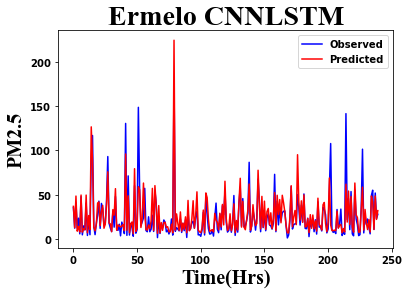

In [31]:
rcParams['font.weight'] = 'bold'
plt.plot(Y_tests[0:240], color='blue', label = 'Observed')
plt.plot(predictions[0:240], color='red', label = 'Predicted')
plt.ylabel('PM2.5', fontname="Times New Roman", size=20,fontweight="bold")
plt.xlabel('Time(Hrs)', fontname="Times New Roman", size=20,fontweight="bold")
plt.title('Ermelo CNNLSTM', fontname="Times New Roman", size=28,fontweight="bold")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)
plt.show()

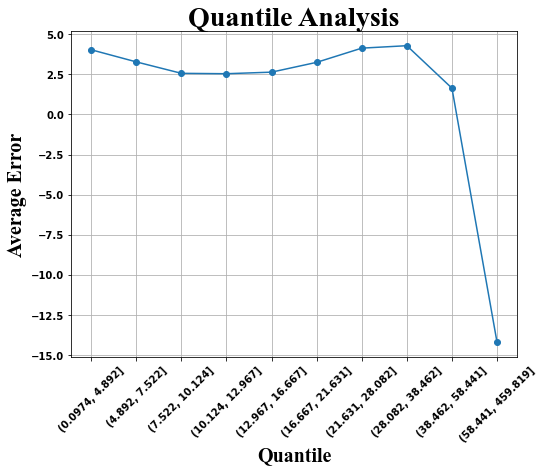

In [30]:
## Calculate errors
errors = predictions.flatten() - Y_tests

# Calculate quantiles based on actual values
quantiles, bins = pd.qcut(Y_tests, q=10, duplicates='drop', retbins=True)

# Calculate average error for each quantile
quantile_errors = []
for i in range(len(bins) - 1):
    group_indices = np.where((Y_tests >= bins[i]) & (Y_tests < bins[i+1]))[0]
    quantile_errors.append(errors[group_indices].mean())

# Plot quantiles vs. average errors
rcParams['font.weight'] = 'bold'
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(quantiles.categories) + 1), quantile_errors, marker='o')
plt.xlabel('Quantile', fontname="Times New Roman", size=20,fontweight="bold")
plt.ylabel('Average Error', fontname="Times New Roman", size=20,fontweight="bold")
plt.title('Quantile Analysis', fontname="Times New Roman", size=28,fontweight="bold")
plt.xticks(range(1, len(quantiles.categories) + 1), [str(q) for q in quantiles.categories], rotation=45)
plt.grid(True)
plt.show()

In [ ]:
# eMalahleni PM2.5
model.save('cnnlstm_model.h5')
#model.save('cnnlstm_modelPM1.h5')
#model.save('cnnlstm_modelSO2.h5')
#model.save('cnnlstm_modelNO2.h5')

In [ ]:
# Ermelo PM2.5
#model.save('cnnlstm_modelEPM2.h5')
model.save('cnnlstm_modelEPM1.h5')
#model.save('cnnlstm_modelESO2.h5')
#model.save('cnnlstm_modelENO2.h5')

In [ ]:
# Hendrina PM2.5
#model.save('cnnlstm_modelHPM2.h5')
#model.save('cnnlstm_modelHPM1.h5')
model.save('cnnlstm_modelHSO2.h5')
#model.save('cnnlstm_modelHNO2.h5')

In [ ]:
# Middelburg PM2.5
#model.save('cnnlstm_modelMPM2.h5')
#model.save('cnnlstm_modelMPM1.h5')
#model.save('cnnlstm_modelMSO2.h5')
model.save('cnnlstm_modelMNO2.h5')

In [ ]:
# Secunda PM2.5
#model.save('cnnlstm_modelSPM2.h5')
#model.save('cnnlstm_modelSPM1.h5')
model.save('cnnlstm_modelSSO2.h5')
model.save('cnnlstm_modelSNO2.h5')